In [1]:
%load_ext autoreload
%autoreload 2

In [59]:
import qcsys as qs
import jax.numpy as jnp

# Helpers

In [60]:
""" ATS Exploration Helpers. """


from jax import jit
from jax import config
import jax.numpy as jnp
import matplotlib.pyplot as plt 
import matplotlib as mpl
import numpy as np



config.update("jax_enable_x64", True)
jnp.set_printoptions(linewidth=jnp.inf)

import qcsys as qs

@jit
def calc_ats_spectrum(ats_old, phi_delta_ext, phi_sum_ext):
    ats_new = qs.ATS.create(
        20, 
        {
            "Ec": ats_old.params["Ec"], 
            "El": ats_old.params["El"], 
            "Ej": ats_old.params["Ej"], 
            "Ej2":ats_old.params["Ej2"], 
            "dEj":ats_old.params["dEj"] , 
            "phi_delta_ext": phi_delta_ext, 
            "phi_sum_ext": phi_sum_ext},
            use_linear=False
    )

    devices = [ats_new]
    system = qs.System.create(devices, couplings=[])

    Es, kets = system.calculate_eig_linear()

    return Es, kets, ats_new

@jit
def calc_ats_storage_spectrum(ats_old, resonator, ϕ0, phi_delta_ext, phi_sum_ext):
    ats_new = qs.ATS.create(
        20, 
        {
            "Ec": ats_old.params["Ec"], 
            "El": ats_old.params["El"], 
            "Ej": ats_old.params["Ej"], 
            "Ej2":ats_old.params["Ej2"], 
            "dEj":ats_old.params/["dEj"] , 
            "phi_delta_ext": phi_delta_ext, 
            "phi_sum_ext": phi_sum_ext},
            use_linear=False
    )

    devices = [resonator, ats_new]
    Ns = [device.N for device in devices]

    r_indx = 0
    b_indx = 1

    dEj = ats_new.params["dEj"]
    Ej2 = ats_new.params["Ej2"]

    id_op_b = qs.promote(ats_new.ops["id"], b_indx, Ns)
    phi_delta_ext_op = phi_delta_ext * id_op_b 
    phi_b = qs.promote(ats_new.ops["phi"], b_indx, Ns)

    a0 = qs.promote(resonator.ops["a"], r_indx, Ns)
    a0_dag = qs.promote(resonator.ops["a_dag"], r_indx, Ns)
    phi_a = ϕ0["ATS0"]["Resonator0"] * (a0 + a0_dag)

    phi = phi_a + phi_b

    gen_ats_term = lambda x : (
            2 * dEj * qs.sinm(x +  2 * jnp.pi * phi_delta_ext_op) * jnp.sin(2 * jnp.pi * phi_sum_ext) +
            2 * Ej2 * qs.cosm(2*x + 2 * 2 * jnp.pi * phi_delta_ext_op) * jnp.cos(2 * 2 * jnp.pi * phi_sum_ext)
        )

    coupling_term += gen_ats_term(phi)
    coupling_term -= gen_ats_term(phi_b)

    system = qs.System.create(devices, couplings=[])

    Es, kets = system.calculate_eig_linear()

    return Es, kets, ats_new

def calc_ats_spectrum_grid(ats, phi_delta_exts, phi_sum_exts):
    x = phi_delta_exts
    y = phi_sum_exts
    xv, yv = jnp.meshgrid(x, y, indexing='xy')

    Es = np.zeros((len(y), len(x))) * np.nan
    for i in range(len(x)):
        for j in range(len(y)):
            Es_curr = calc_ats_spectrum(ats, xv[j,i], yv[j,i])[0]
            Es[j,i] = Es_curr[1] - Es_curr[0]
    return xv, yv, Es


def plot_ats_spectrum_grid(xv, yv, Es, vmax=None, vmin=None, cmap="viridis", ptype="contour", **kwargs):
    fig, axs = plt.subplots(1, 1, figsize=(4, 3), dpi=200, squeeze=False)
    
    ax = axs[0][0]
    im = getattr(ax, ptype)(xv, yv, Es, cmap=cmap, vmax=vmax, vmin=vmin, **kwargs) # , vmin=0, vmax=1000)
    ax.set_xlabel("$\\Phi_{\\Delta}/ \\Phi_0$")
    ax.set_ylabel("$\\Phi_{\\Sigma}/ \\Phi_0$")
    fig.colorbar(im, orientation='vertical')
    fig.tight_layout()

    return axs

def calc_ats_spectrum_line(ats, sweep_vals, other_flux_fixed_point, sweep_delta=True):
    Es = []
    for sweep_val in sweep_vals:
        if sweep_delta:
            Es_curr, _, _ = calc_ats_spectrum(ats, sweep_val, other_flux_fixed_point)
        else:
            Es_curr, _, _ = calc_ats_spectrum(ats, other_flux_fixed_point, sweep_val)
        Es.append(Es_curr)

    Es = jnp.array(Es)
    return Es

def plot_ats_spectrum_line(Es, sweep_vals, xlim=None, ylim=None, sweep_delta=False):
    fig, axs = plt.subplots(2,1, figsize=(4,4), dpi=200, squeeze=False)

    if sweep_delta:
        sweep_label = "$\\Phi_{\\Delta}/\\Phi_{0}$"
    else:
        sweep_label = "$\\Phi_{\\Sigma}/\\Phi_{0}$"

    ax = axs[0][0]
    Es_plot = Es
    ax.plot(sweep_vals, Es_plot)
    ax.set_xlabel(sweep_label)
    ax.set_ylabel("$E$ [GHz]")
    ax.set_xlim(xlim)

    
    ax = axs[1][0]
    Es_plot = Es[:,:] - Es[:, 0].reshape(Es.shape[0], 1)
    ax.plot(sweep_vals, Es_plot)
    ax.set_xlabel(sweep_label)
    ax.set_ylabel("$E - E_g$ [GHz]")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)

    fig.tight_layout()

    return axs

# Analysis

In [189]:
0.08483122986038028e3

84.83122986038028

In [223]:
ats = qs.ATS.create(
    25, 
    {
        "Ec": 80e-3, 
        "El": 60, 
        "Ej": 30, 
        "Ej2": 0, 
        "dEj": 0, 
        "phi_delta_ext": 0, 
        "phi_sum_ext": 0
    },
    # {'Ec': 0.08483122986038028, 'Ej': 1788.0606387960322, 'Ej2': 0, 'El': 35.625753636617915, 'dEj': 0, 'phi_delta_ext': 0.0, 'phi_sum_ext': 0.25},
    use_linear=False
)


# ATS: {'Ec': 0.08483122986038028, 'Ej': 1788.0606387960322, 'Ej2': 17.88, 'El': 35.625753636617915, 'dEj': 25.2861385, 'phi_delta_ext': 0.0, 'phi_sum_ext': 0.25}

### 2D Plots

In [224]:
phi_delta_exts = jnp.linspace(-0.75, 0.75, 201)
phi_sum_exts = jnp.linspace(-0.5,0.5, 201)
xv, yv, Es = calc_ats_spectrum_grid(ats, phi_delta_exts, phi_sum_exts)

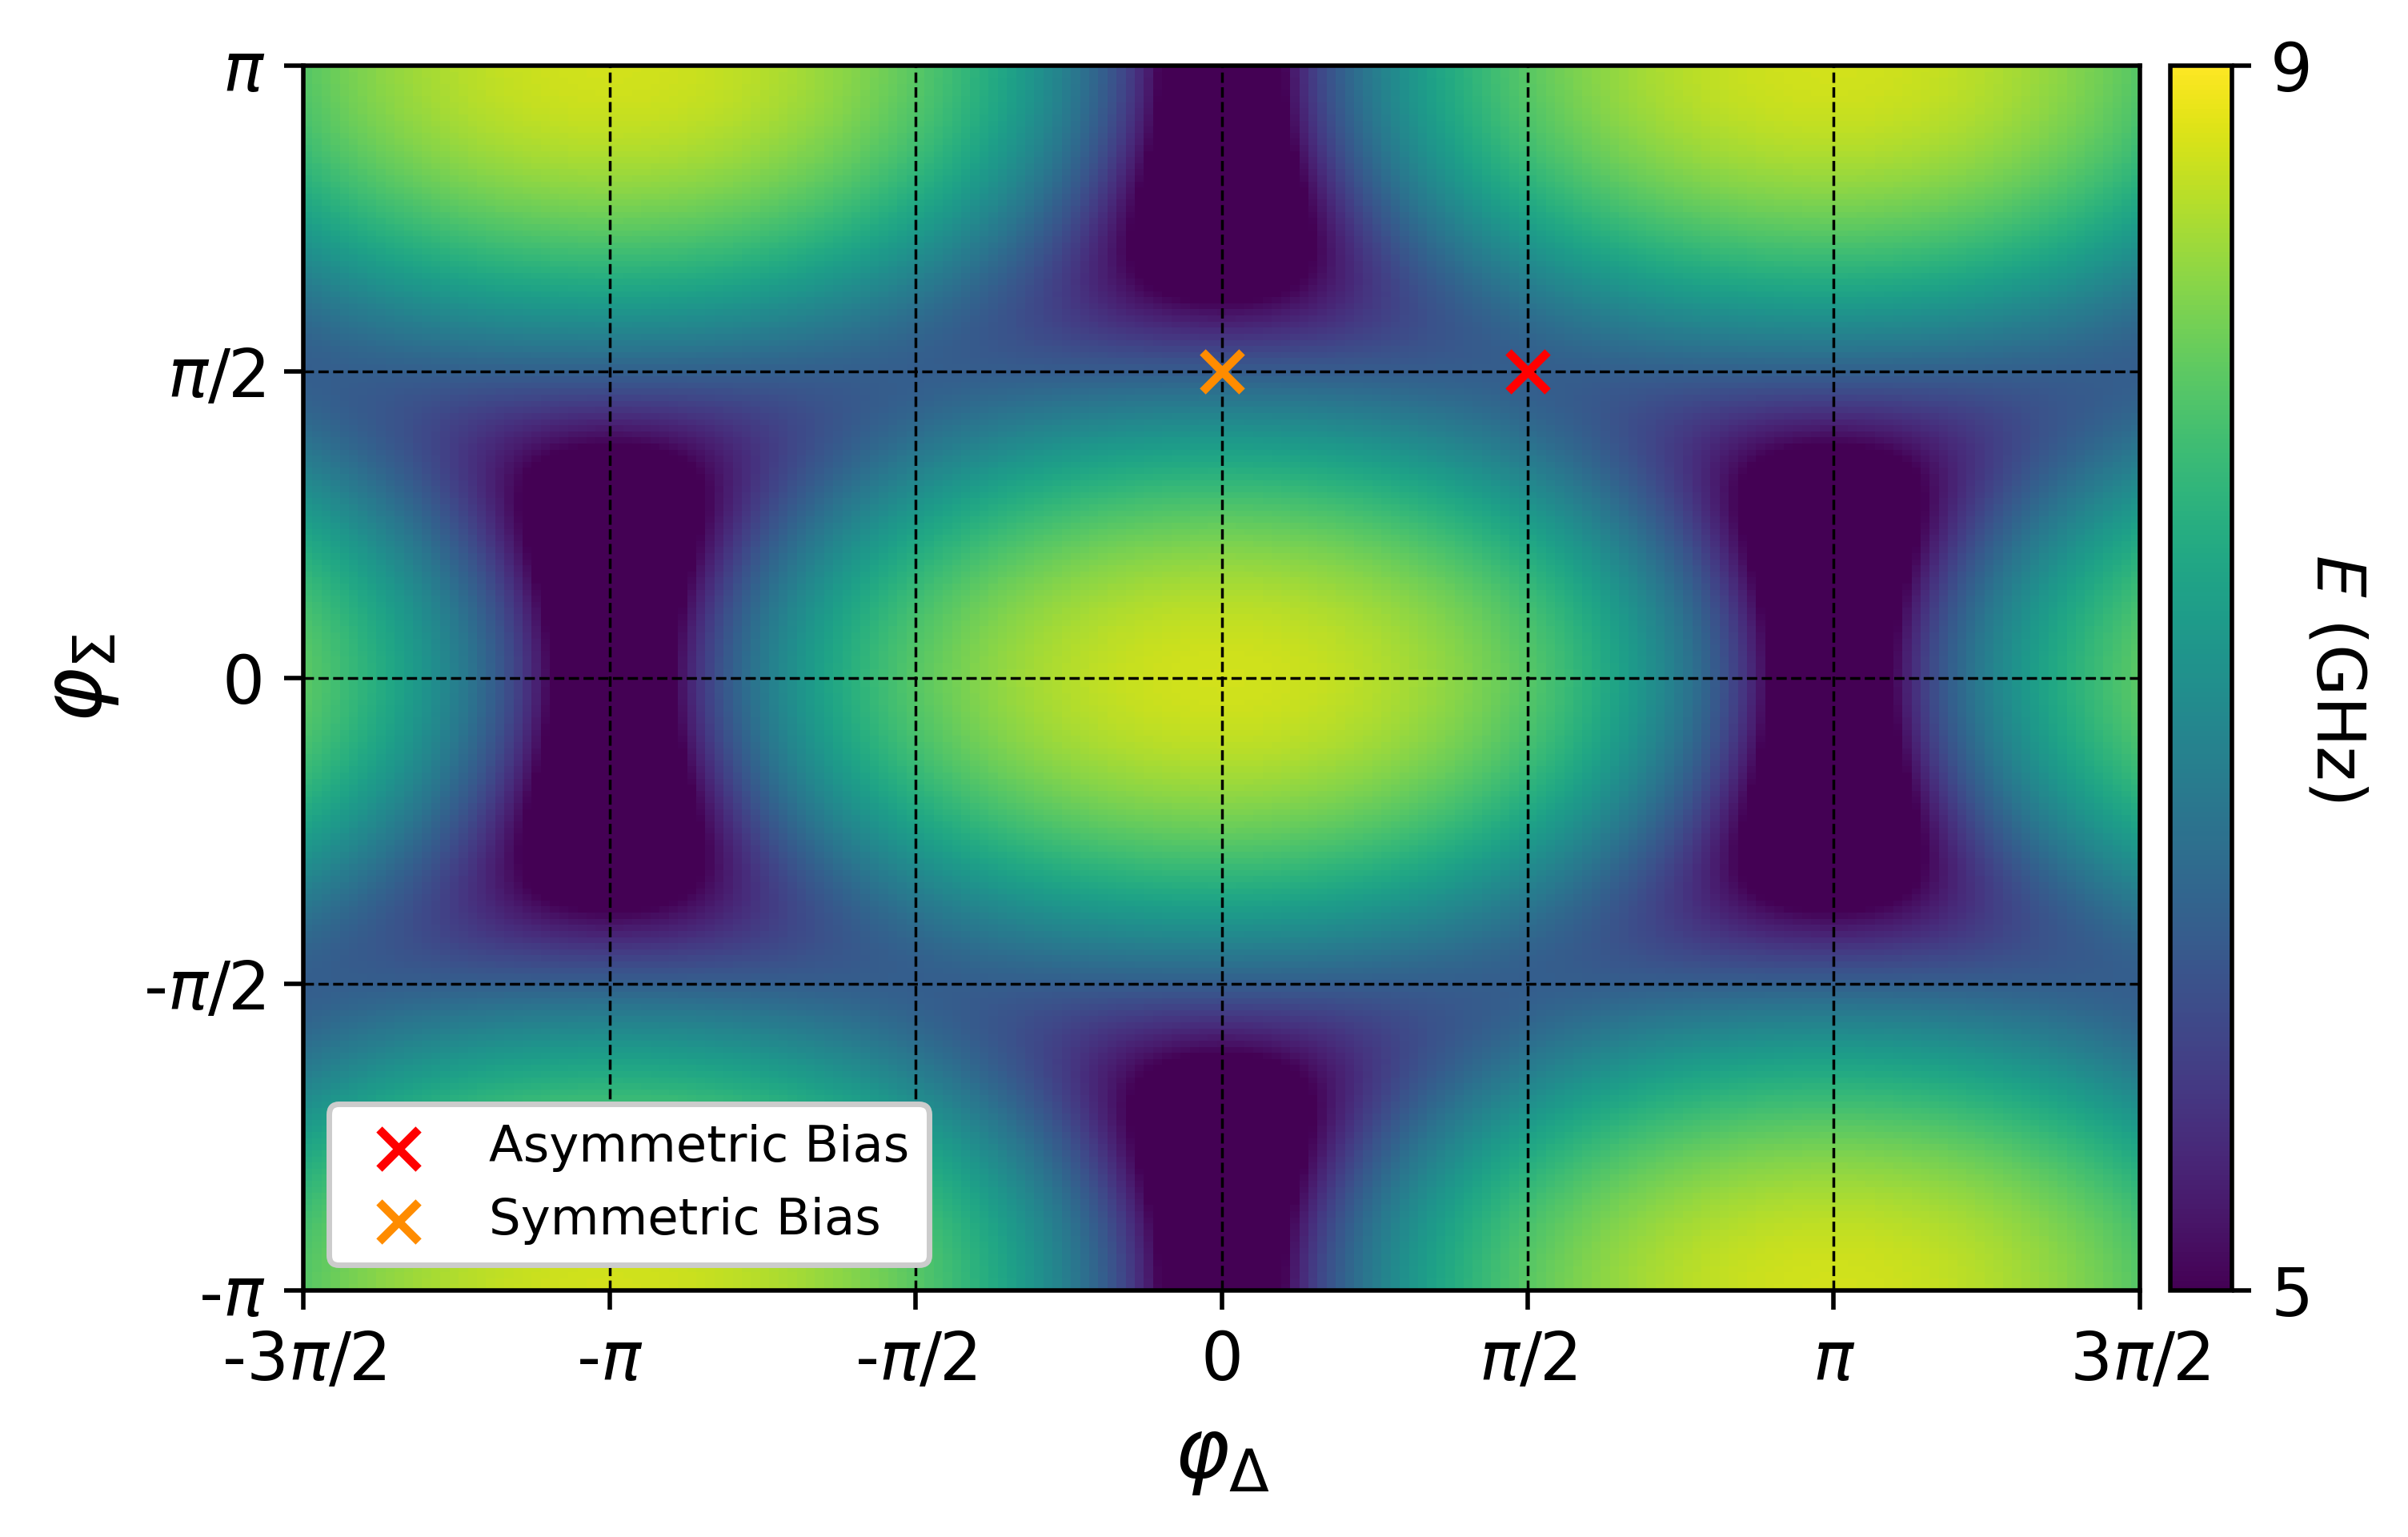

In [228]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=500)

font = {'size'   : 12}
mpl.rc('font', **font)

im = ax.imshow(Es, extent=[np.min(xv), np.max(xv), np.min(yv), np.max(yv)], cmap="viridis", vmin=5, vmax=9, origin="lower", aspect="auto")

ax.set_xlabel(r"$\varphi_{\Delta}$", fontsize=15)
ax.set_ylabel(r"$\varphi_{\Sigma}$", fontsize=15)
ax.set_xticks([-0.75, -0.5, -0.25, 0, 0.25, 0.5, 0.75])
ax.set_xticklabels([r"-$3\pi/2$", r"-$\pi$", r"-$\pi/2$", "0", r"$\pi/2$", r"$\pi$", r"$3\pi/2$"])

ax.set_yticks([-0.5, -0.25, 0, 0.25, 0.5])
ax.set_yticklabels([r"-$\pi$", r"-$\pi/2$", "0", r"$\pi/2$", r"$\pi$"])

ax.scatter(0.25, 0.25, s=50, c="r", marker="x", label="Asymmetric Bias", zorder=2)
ax.scatter(0, 0.25, s=50, c="darkorange", marker="x", label="Symmetric Bias", zorder=2)

for y in [-0.25, 0, 0.25]:
    ax.axhline(y, c="k", lw=0.5, ls="--", zorder=1)

for x in [-0.5, -0.25, 0, 0.25, 0.5]:
    ax.axvline(x, c="k", lw=0.5, ls="--", zorder=1)

ax.legend(fontsize=9, framealpha=1, loc="lower left")

ax.set_aspect('equal')
plt.tight_layout()

cb = fig.colorbar(im, pad=0.01)
cb.set_label("$E$ (GHz)", rotation = -90, labelpad=10)
cb.ax.set_yticks([5.0, 9])

# plt.savefig("ats_spectrum2.pdf")

# FCD 

In [390]:
import scipy as sp

In [661]:
n_pts = 51; T = 2
ts_1 = np.linspace(0, 0.25, n_pts) * T
ts_2 = np.linspace(0.25, 0.75, n_pts * 2) * T
ts_3 = np.linspace(0.75, 1, n_pts) * T

zt_1 = np.ones_like(ts_1)
zt_2 = -np.ones_like(ts_2)
zt_3 = np.ones_like(ts_3)

χ = 4

phi_t1 = -(χ/2) * (sp.integrate.cumulative_trapezoid(zt_1, ts_1, initial=0))
phi_t2 = phi_t1[-1] - (χ/2) * (sp.integrate.cumulative_trapezoid(zt_2, ts_2, initial=0))
phi_t3 = phi_t2[-1] - (χ/2) * (sp.integrate.cumulative_trapezoid(zt_3, ts_3, initial=0))

ts = np.concatenate([ts_1, ts_2, ts_3])
phi_ts = np.concatenate([phi_t1, phi_t2, phi_t3])
zts = np.concatenate([zt_1, zt_2, zt_3])

In [662]:
np.trapz(np.sin(phi_ts), ts)

-5.551115123125783e-17

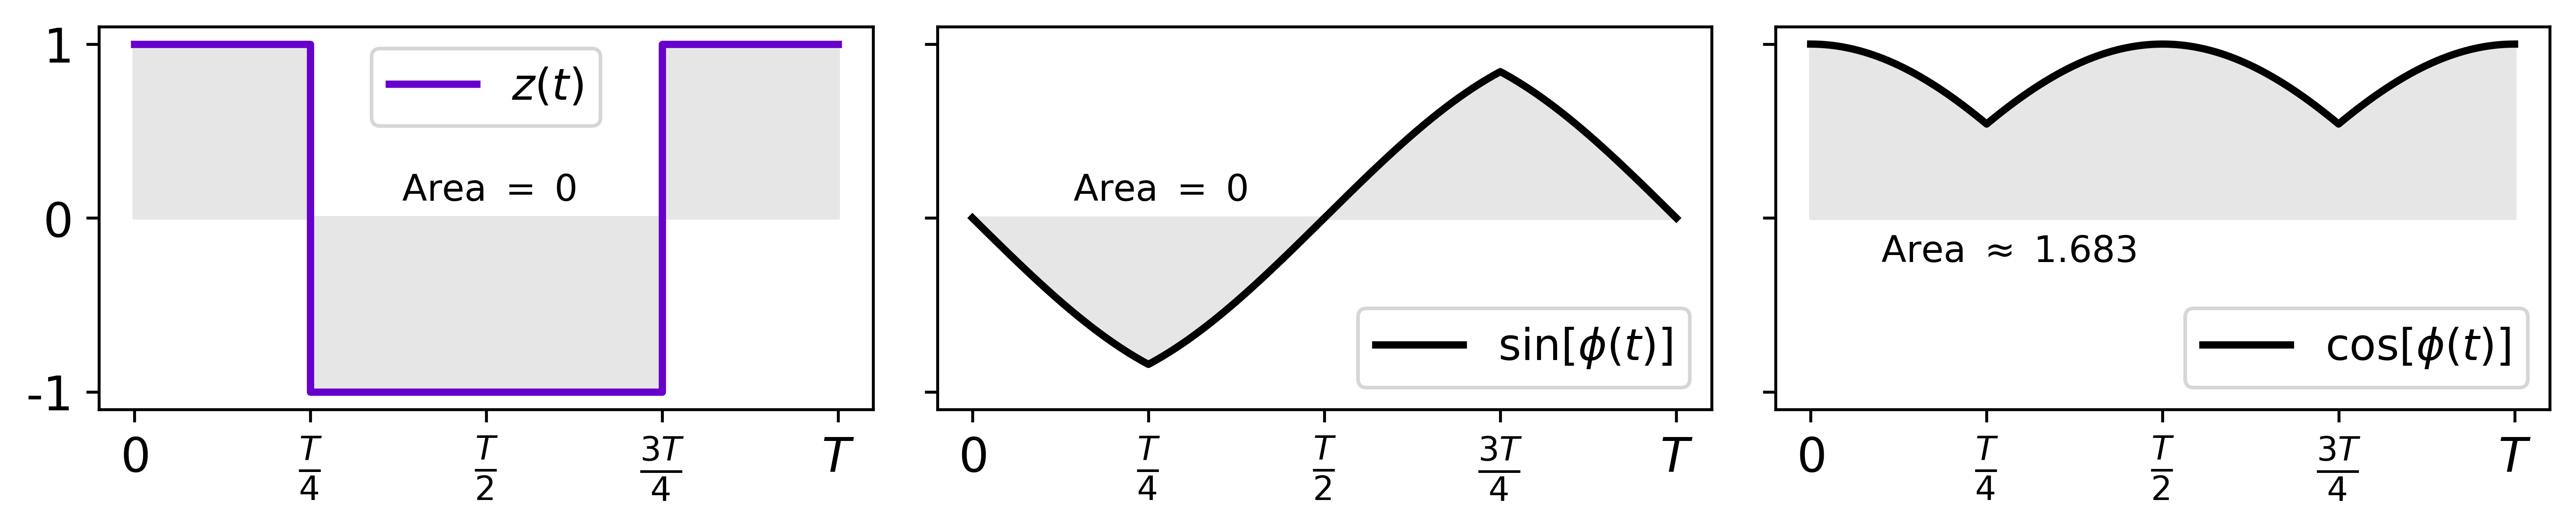

In [663]:
fig, axs = plt.subplots(1, 3, figsize=(10, 2.2), dpi=600, sharex=True, sharey=True)

font = {'size'   : 13}
mpl.rc('font', **font)


axs[0].plot(ts, zts, color="#6800ccff", lw=2)
axs[0].fill_between(ts, zts, color="0.9")
axs[0].set_yticks([-1, 0, 1]); axs[0].set_yticklabels([-1, 0, 1])
axs[0].set_xticks([0, T/4, T/2, 3*T/4, T])
axs[0].set_xticklabels(["$0$", "$\\frac{T}{4}$", "$\\frac{T}{2}$", "$\\frac{3T}{4}$", r"$T$"])
axs[0].legend([r"$z(t)$"], fontsize=12, loc="upper center")
axs[0].text(0.38*T, 0.1, fr"Area $=$ {np.abs(np.trapz(zts, ts)):.0f}", fontsize=10)


axs[1].plot(ts, np.sin(phi_ts), '-', color="k", lw=2)
axs[1].fill_between(ts, np.sin(phi_ts), '-', color="0.9")
axs[1].legend([r"$\sin[\phi(t)]$"], fontsize=12, loc="lower right")
# axs[1].text(T/6, 0.1, fr"Area = 0", fontsize=10)
axs[1].text(T/7, 0.1, fr"Area $=$ {np.abs(np.trapz(np.sin(phi_ts), ts)):.0f}", fontsize=10)


axs[2].plot(ts, np.cos(phi_ts), '-', color="k", lw=2)
axs[2].fill_between(ts, np.cos(phi_ts), '-', color="0.9")
axs[2].legend([r"$\cos[\phi(t)]$"], fontsize=12, loc="lower right")
axs[2].text(0.1*T, -0.25, fr"Area $\approx$ {np.abs(np.trapz(np.cos(phi_ts), ts)):.3f}", fontsize=10)


plt.tight_layout()
plt.savefig("double_echo_FCD.pdf")